In [1]:
import numpy as np
import pandas as pd
import os.path as osp
import math
import matplotlib.pyplot as plt

In [3]:
num_method = 3
num_pattern = 11
window_size = 50
overlap = 10
root_path = 'D:\A-Deep-Learning-Based-Illegal-Insider-Trading-Detection-and-Prediction-Technique-in-Stock-Market\detection'

actual_data_df = pd.read_csv(osp.join(root_path, 'input/bp_full_window_act.csv'), header = None)
predicted_data_window_based = pd.read_csv(osp.join(root_path, 'input/bp_full_window_pred.csv'), header = None)
predicted_data_day_based = pd.read_csv(osp.join(root_path, 'input/bp_full_point_pred.csv'), header = None)
predicted_data_historical_based = pd.read_csv(osp.join(root_path, 'input/bp_full_sequence_pred.csv'), header = None)
pattern_mat = pd.read_csv(osp.join(root_path, 'input/pattern.csv'), header = None, names = [i for i in range(50)])
pattern_desc_arr = pd.read_csv(osp.join(root_path, 'input/pattern_sizes.csv'), header = None)

In [4]:
methods = [
    [len(predicted_data_window_based), math.ceil(len(predicted_data_window_based) / window_size)],
    [len(predicted_data_day_based), math.ceil(len(predicted_data_day_based) / window_size)],
    [len(predicted_data_historical_based), math.ceil(len(predicted_data_historical_based) / window_size)]
]

In [6]:
def normalized_cross_correlation(method, window, pattern, day):
    global results
    
    title_mode = ['Window', 'Day', 'Historical'][method - 1]
    graph_title1 = 'True vs predicted (' + title_mode + ') [w=' + str(window) + ', p =' + str(pattern) + ', d=' + str(day) + ')'
    graph_title2 = 'Day lag vs normalized cross correlation [w=' + str(window) + ', p=' + str(pattern) + ', d=' + str(day) + ')'

    actual_data = actual_data_df.iloc[:, 0]
    predicted_data = predicted_data_historical_based.iloc[:,0] if method == 3 else predicted_data_window_based.iloc[:,0]

    if pattern == 0:
        signal1_start = ((window - 1) * window_size) + 1;
        signal1_end = min(signal1_start + window_size - 1, len(predicted_data))

        signal2_start = signal1_start
        signal2_end = signal1_end
        
        signal1 = predicted_data[signal1_start : signal1_end]
        signal2 = actual_data[signal2_start: signal2_end]
    elif pattern > 0:
        signal1_start = ((window - 1) * window_size) + day;
        signal1_end = min(signal1_start + pattern_desc_arr.iloc[0, pattern - 1] - 1, len(predicted_data))

        signal1 = predicted_data[signal1_start:signal1_end]
        signal2 = pattern_mat.iloc[pattern - 1, :pattern_desc_arr.iloc[0, pattern - 1]]


    if len(signal1) == len(signal2):
        lag, cor_sequence, _, _ = plt.xcorr(signal1, signal2, 'coeff')
        if max(cor_sequence) > 80:
            results.append([method, window, pattern, day])
            x1 = np.linspace(1, len(signal1), len(signal1))
            plt.xlabel('day')
            plt.ylabel('volume')
            plt.title(graph_title1)
            plt.plot(x1, signal1)
            plt.plot(x1, signal2)

            plt.plot(lag, cor_sequence)
            max_index = np.argmax(cor_sequence)
            max_cor = cor_sequence[max_index]
            plt.xlabel({'Day Lag', 'Maximum ncr = ' + str(max_cor) + ' at day lag = ' + str(max_index)})
            plt.ylabel('normalized cross correlation')
            plt.title(graph_title2)

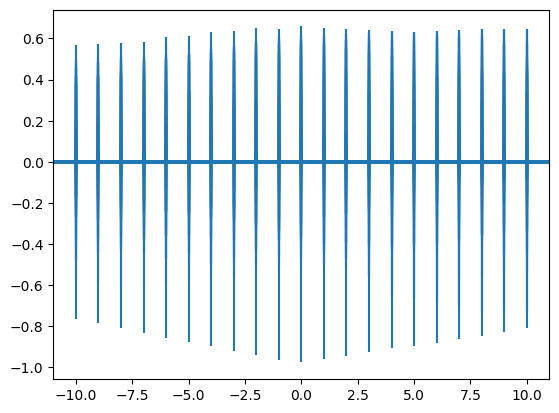

In [7]:
results = []
for method in range(3):
    num_window = methods[method][1] - 1
    for window in range(num_window):
        normalized_cross_correlation(method + 1, window + 1, 0, 0);
        for pattern in range(num_pattern):
            overlap = 10
            if (window + 1) == num_window:
                overlap = 0
            for day in range(window_size - (pattern_desc_arr.iloc[0, pattern] - overlap)):
                normalized_cross_correlation(method + 1, window + 1, pattern + 1, day + 1);

In [21]:
print(results)

[]


In [17]:
result_header = ['Method', 'Window', 'Pattern', 'Day']
df = pd.DataFrame(data=results, columns=result_header)
df.to_csv(osp.join(root_path, 'output/final_output.csv'))

In [20]:
df = pd.read_csv("output/final_output.csv")
print(df)

Empty DataFrame
Columns: [Unnamed: 0, Method, Window, Pattern, Day]
Index: []
